In [3]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../../")


from dataloaders import data_set, data_dict
import torch
import yaml
import os
import pandas as pd
import matplotlib.pyplot as plt
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
args = dotdict()   

args.freq_save_path   = r"/mnt/c/Users/Murat/Desktop/Bachelor/Freq_data"
args.window_save_path = r"/mnt/c/Users/Murat/Desktop/Bachelor/Sliding_window"
args.root_path        = r"/mnt/c/Users/Murat/Desktop/Bachelor/datasets"

args.drop_transition  = False

args.batch_size       = 128
args.shuffle          = True
args.drop_last        = False
args.train_vali_quote = 0.85

In [5]:
# dataset to be used
args.data_name           =  "hapt"  # rw hapt

# whether to calculate augmentation difference
args.difference          =  False 

# whether to do augmentation  filtering
args.filtering           =  False

# whether to do augmentation  magnitude
args.magnitude           =  False
args.weighted_sampler    =  False


# whether to do wavelet_filtering and configuration
args.wavelet_filtering   = False
args.number_wavelet_filtering = 10

# how to normalize the data
args.datanorm_type       =  "standardization" # None ,"standardization", "minmax"

# select position on body
args.pos_select          = None

# select sensor
args.sensor_select       = None



args.representation_type = "time"
args.exp_mode            = "LOCV"

config_file = open('../../configs/data.yaml', mode='r')
data_config = yaml.load(config_file, Loader=yaml.FullLoader)
config = data_config[args.data_name]
args.root_path       = os.path.join(args.root_path,config["filename"])
args.sampling_freq   = config["sampling_freq"]
window_seconds       = config["window_seconds"]
args.windowsize      =   int(window_seconds * args.sampling_freq) 
args.c_in            =  config["num_channels"]

args.input_length    =  args.windowsize

# input information
if args.wavelet_filtering:
    
    if args.windowsize%2==1:
        N_ds = int(torch.log2(torch.tensor(args.windowsize-1)).floor()) - 2
    else:
        N_ds = int(torch.log2(torch.tensor(args.windowsize)).floor()) - 2

    args.f_in            =  args.number_wavelet_filtering*N_ds+1
else:
    args.f_in            =  1

In [6]:
# load the dataset
dataset = data_dict[args.data_name](args)

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------


In [7]:
color_map = {"acc_x":'#1f77b4',"acc_y":'#ff7f0e', "acc_z":'#2ca02c',
              "gyro_x":'#d62728',"gyro_y":'#9467bd',"gyro_z":'#8c564b'}
acc_cols = ["acc_x","acc_y","acc_z"]
gyro_cols = ["gyro_x","gyro_y","gyro_z"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [8]:
label_map = {}
for item in dataset.label_map:
    label_map[item[0]] = item[1]

Calculate window values and labels

In [9]:
sample_count = len(dataset.train_slidingwindows)
window_values = []
window_labels = []
print(sample_count)

for i in range(sample_count):
    # Q1: what does the first element of train_slidingwindows[index] represent? 
    # ['3_5', 90948, 91076]
    window_start = dataset.train_slidingwindows[i][1]
    window_end = dataset.train_slidingwindows[i][2]
    window_values.append(dataset.data_x.iloc[window_start:window_end, 1:-1])
    window_values[i].columns = ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]
    window_values[i].reset_index(drop=True, inplace=True)
    window_labels.append(dataset.data_y.iloc[window_start:window_end].mode().loc[0])

12734


Set index for examples

In [22]:
index = 1000

Accelerometer Data

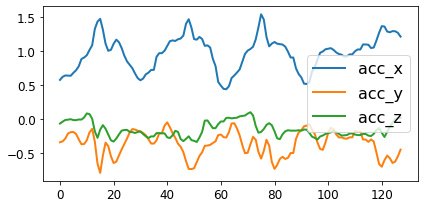

In [23]:
plt.figure(figsize=(6,3))
for col in acc_cols:
    plt.plot(window_values[index][col],c = color_map[col], linewidth=2,label = col)
plt.legend(fontsize=16)
# plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\original_acc.png",dpi=800,transparent=True)
plt.show()

Gyroscope Data

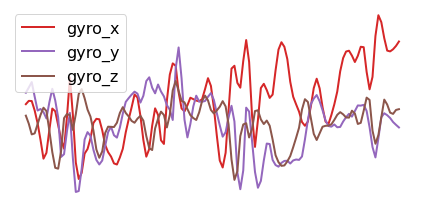

In [24]:
plt.figure(figsize=(6,3))
for col in gyro_cols:
    plt.plot(window_values[index][col],c = color_map[col], linewidth=2,label = col)
plt.legend(fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\original_gyro.png",dpi=800,transparent=True)
plt.show()

Channel Augmentation Configuration

In [25]:
from scipy import signal
fc1 = 0.3  # Cut-off frequency of the filter
w1 = fc1 / (50 / 2) # Normalize the frequency

fc2 = 20  # Cut-off frequency of the filter
w2 = fc2 / (50 / 2) # Normalize the frequency

b1, a1 = signal.butter(2, w1, 'low')
b2, a2 = signal.butter(2, [w1,w2], 'band')

Calculating difference & Separating body and gravitation

In [26]:
grav_acc_xyz = []
body_acc_xyz = []
diff_acc_xyz = []
window_value = window_values[index]
for window_value in window_values:
    window_grav_acc_xyz = {}
    window_body_acc_xyz = {}
    window_diff_acc_xyz = {}
    for col in acc_cols:
        acc = window_value[col]
        b1, a1 = signal.butter(2, w1, 'low')
        grav = signal.filtfilt(b1, a1, acc)
        b2, a2 = signal.butter(2, [w1,w2], 'band')
        body = signal.filtfilt(b2, a2, acc)

        diff = acc.diff()
        # plt.figure(figsize=(6,2))
        # plt.plot(grav, label='grav_'+col,c = color_map[col], linewidth=2)
        # plt.legend(fontsize=12)
        # #plt.axis('off')
        # plt.xticks(fontsize=12)
        # plt.yticks(fontsize=12)
        # plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('grav_'+col),dpi=300,transparent=True)
        # plt.show()    

        # plt.figure(figsize=(6,2))
        # plt.plot(body, label='body_'+col,c = color_map[col], linewidth=2)
        # plt.legend(fontsize=12)
        # #plt.axis('off')
        # plt.xticks(fontsize=12)
        # plt.yticks(fontsize=12)
        # plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('body_'+col),dpi=300,transparent=True)
        # plt.show()

        # plt.figure(figsize=(6,2))
        # plt.plot(diff, label='diff_'+col,c = color_map[col], linewidth=2)
        # plt.legend(fontsize=12)
        # #plt.axis('off')
        # plt.xticks(fontsize=12)
        # plt.yticks(fontsize=12)
        # plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('diff_'+col),dpi=300,transparent=True)
        # plt.show()

        window_grav_acc_xyz[col] = grav
        window_body_acc_xyz[col] = body
        window_diff_acc_xyz[col] = diff
    grav_acc_xyz.append(window_grav_acc_xyz)
    body_acc_xyz.append(window_body_acc_xyz)
    diff_acc_xyz.append(window_diff_acc_xyz)
    

Example result

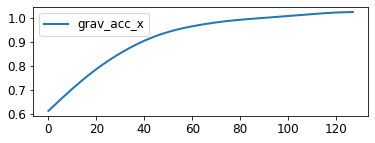

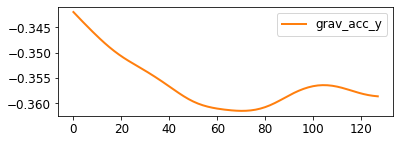

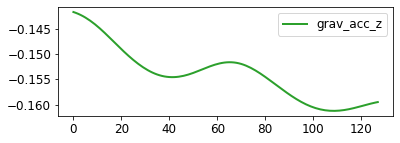

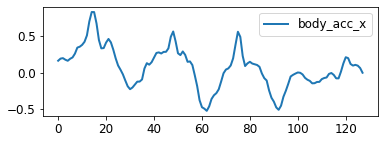

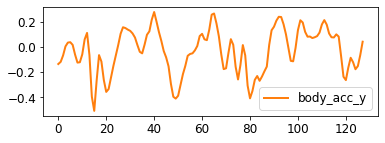

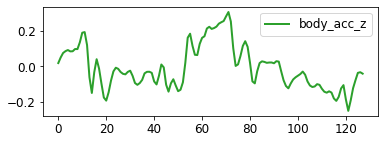

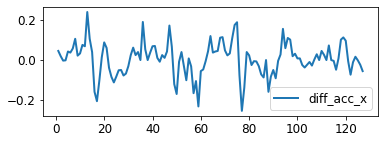

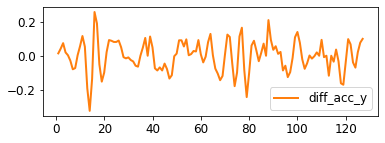

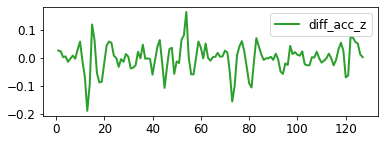

In [27]:
for col in acc_cols:
    plt.figure(figsize=(6,2))
    plt.plot(grav_acc_xyz[index][col], label='grav_'+col,c = color_map[col], linewidth=2)
    plt.legend(fontsize=12)
    #plt.axis('off')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('grav_'+col),dpi=300,transparent=True)
    plt.show()

for col in acc_cols:
    plt.figure(figsize=(6,2))
    plt.plot(body_acc_xyz[index][col], label='body_'+col,c = color_map[col], linewidth=2)
    plt.legend(fontsize=12)
    #plt.axis('off')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('body_'+col),dpi=300,transparent=True)
    plt.show()

for col in acc_cols:
    plt.figure(figsize=(6,2))
    plt.plot(diff_acc_xyz[index][col], label='diff_'+col,c = color_map[col], linewidth=2)
    plt.legend(fontsize=12)
    #plt.axis('off')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('diff_'+col),dpi=300,transparent=True)
    plt.show()

Define magnitude function

In [29]:
import numpy as np
import math
def mag_3_signals(x,y,z):# magnitude function redefinition
    return np.array([math.sqrt((x[i]**2+y[i]**2+z[i]**2)) for i in range(len(x))])

Calculate magnitude for gravity channel

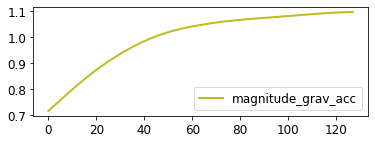

In [30]:
cols = list(grav_acc_xyz[index].keys())
mag_grav_acc = []
for window_grav_acc_xyz in grav_acc_xyz:
    mag_grav_acc.append(mag_3_signals(window_grav_acc_xyz[cols[0]], window_grav_acc_xyz[cols[1]], window_grav_acc_xyz[cols[2]]))

plt.figure(figsize=(6,2))
plt.plot(mag_grav_acc[index], label='magnitude_grav_acc',c = '#bcbd22', linewidth=2)
plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('magnitude_grav_acc'),dpi=300,transparent=True)
plt.show()

Calculate magnitude for body channel

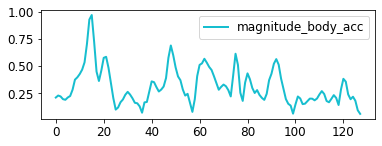

In [31]:
cols = list(body_acc_xyz[index].keys())
mag_body_acc = []
for window_body_acc_xyz in body_acc_xyz:
    mag_body_acc.append(mag_3_signals(window_body_acc_xyz[cols[0]], window_body_acc_xyz[cols[1]], window_body_acc_xyz[cols[2]]))

plt.figure(figsize=(6,2))
plt.plot(mag_body_acc[index], label='magnitude_body_acc',c = '#17becf', linewidth=2)
plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r"/mnt/c/Users/Murat/Desktop/Bachelor/images\{}.png".format('magnitude_body_acc'),dpi=300,transparent=True)
plt.show()

Mixup Augmentation

In [99]:
def mixup(sample1, sample2, mixup_lambda):
    sample1 = pd.DataFrame(sample1)
    sample2 = pd.DataFrame(sample2) # Q3 we already pass them as dataframes, are those lines needed
    x1 = sample1.values
    x2 = sample2.values
    x = mixup_lambda * x1 + (1 - mixup_lambda) * x2
    x = pd.DataFrame(x)
    x.columns = list(sample1.columns)
    return x

In [100]:
pMixup = np.random.random()

# mixup parameter, can be moved inside the loop, maybe change the used distribution to beta
mixup_lambda = np.random.random() 
mixup_set_size = np.random.randint(0, 100)
mixup_indices_set1 = np.random.randint(0, sample_count, mixup_set_size)
mixup_indices_set2 = np.random.randint(0, sample_count, mixup_set_size)


mixup_grav_acc_xyz = []
mixup_body_acc_xyz = []
mixup_diff_acc_xyz = []
mixup_mag_grav_acc = []
mixup_mag_body_acc = []
print(pMixup)
if pMixup > 0.5:
    for i in range(mixup_set_size):
        idx1 = mixup_indices_set1[i]
        idx2 = mixup_indices_set2[i]
        mixup_grav_acc_xyz.append(mixup(grav_acc_xyz[idx1], grav_acc_xyz[idx2], mixup_lambda))
        mixup_body_acc_xyz.append(mixup(body_acc_xyz[idx1], body_acc_xyz[idx2], mixup_lambda))
        mixup_diff_acc_xyz.append(mixup(diff_acc_xyz[idx1], diff_acc_xyz[idx2], mixup_lambda)) # Q2: this returns nan values, is it normal
        mixup_mag_grav_acc.append(mixup(mag_grav_acc[idx1], mag_grav_acc[idx2], mixup_lambda))
        mixup_mag_body_acc.append(mixup(mag_body_acc[idx1], mag_body_acc[idx2], mixup_lambda))



0.5501090824309429


Example Mixup Result

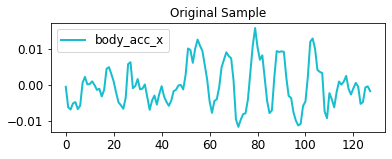

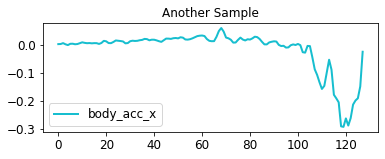

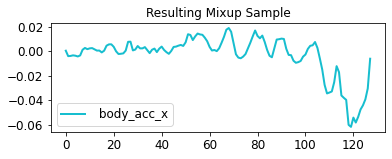

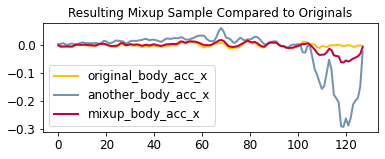

In [124]:
mixup_idx = 0
index1 = mixup_indices_set1[mixup_idx]
index2 = mixup_indices_set2[mixup_idx]

plt.figure(figsize=(6,2))
plt.title('Original Sample')
plt.plot(body_acc_xyz[index1]['acc_x'], label='body_acc_x',c = '#17becf', linewidth=2)
plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(6,2))
plt.title('Another Sample')
plt.plot(body_acc_xyz[index2]['acc_x'], label='body_acc_x',c = '#17becf', linewidth=2)
plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(6,2))
plt.title('Resulting Mixup Sample')
plt.plot(mixup_body_acc_xyz[mixup_idx]['acc_x'], label=' body_acc_x',c = '#17becf', linewidth=2)
plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(6,2))
plt.title('Resulting Mixup Sample Compared to Originals')
plt.plot(body_acc_xyz[index1]['acc_x'], label='original_body_acc_x',c = '#FFC300', linewidth=2)
plt.plot(body_acc_xyz[index2]['acc_x'], label='another_body_acc_x',c = '#7393B3', linewidth=2)
plt.plot(mixup_body_acc_xyz[mixup_idx]['acc_x'], label='mixup_body_acc_x',c = '#C70039', linewidth=2)
plt.legend(fontsize=12)
#plt.axis('off')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### Random Augmentation Definitions

Jitter

In [125]:
import numpy as np
import pandas as pd
def jitter(x, sigma=0.1):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

Exponential Smoothing

In [126]:
def exponential_smoothing(x, alpha=0.5):
    length = x.shape[1]
    ret = np.zeros_like(x)
    for dim in range(x.shape[0]):
        ret[dim,0] =   x[dim,0] 
        for index in range(1,length):
            ret[dim,index] =   alpha * x[dim,index-1] + (1-alpha)* ret[dim,index-1]

    return ret

Moving Average

In [127]:
def moving_average(x):
    df = pd.DataFrame(x.T)
    ret = df.rolling(window =5).mean()
    ret = ret.interpolate(method='linear', limit_direction='both')
    return ret.values

Magnitude Scaling

In [128]:
def magnitude_scaling(x, sigma=0.5):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[1]))
    factor = np.ones_like(factor) * 0.7
    return np.multiply(x, factor[np.newaxis,:])

Magnitude Warping

In [129]:
def magnitude_warp(x, sigma=0.4, knot=6):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[0])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=( knot, x.shape[1]))

    warp_steps = (np.ones((x.shape[1],1))*(np.linspace(0, x.shape[0]-1., num=knot))).T


    warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[:,dim])(orig_steps) for dim in range(x.shape[1])]).T

    ret = x * warper
    #plt.plot(warper)

    return ret

Magnitude Shift

In [130]:
def magnitude_shift(x, ratio=0.2):
    ret = np.zeros_like(x)

    for dim in range(x.shape[0]):
        #print(x[dim,:].mean())
        ret[dim,:] =x[dim,:]+max(np.mean(x[dim,:])*ratio,np.std(x[dim,:])*ratio)
    return ret

Time Warping

In [131]:
def time_warp(x, sigma=0.05, knot=5):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[0])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(knot+2))
    #plt.plot(random_warps)
    warp_steps = (np.ones((x.shape[1],1))*(np.linspace(0, x.shape[0]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)

    for dim in range(x.shape[1]):
        time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps)(orig_steps)
        #plt.figure()
        #plt.plot(time_warp)
        scale = (x.shape[0]-1)/time_warp[-1]
        ret[:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[0]-1), x[:,dim]).T
    return ret

Window Warping

In [132]:
def window_warp(x, window_ratio=0.15, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, 1)
    print(warp_scales)
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)

    window_steps = np.arange(warp_size)
    print(warp_size)
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=1).astype(int)
    print(window_starts)
    window_ends = (window_starts + warp_size).astype(int)
    print(window_ends)            
    ret = np.zeros_like(x)

    for dim in range(x.shape[0]):
        start_seg = x[dim,:window_starts[0]]
        window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[0])), window_steps, x[dim,window_starts[0]:window_ends[0]])
        end_seg = x[dim,window_ends[0]:]

        warped = np.concatenate((start_seg, window_seg, end_seg))                
        ret[dim,:] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret

Window Slicing

In [133]:
def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(1)).astype(int)
    ends = (target_len + starts).astype(int)
    print(starts)
    print(ends)
    ret = np.zeros_like(x)

    for dim in range(x.shape[0]):
        ret[dim,:] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), x[dim,starts[0]:ends[0]]).T
    return ret

Random Sampling

In [134]:
def random_sampling(x, reduce_ratio=0.8):
    import random
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x

    index_list = list(np.arange(x.shape[1]))
    sampled_index = random.sample(index_list, target_len)
    sampled_index = sorted(sampled_index)


    ret = np.zeros_like(x)

    for dim in range(x.shape[0]):
        ret[dim,:] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), x[dim, sampled_index]).T
    return ret

Slope Adding

In [136]:
def slope_adding(x, slope=0.3):
    import random
    anchor = random.randint(0, x.shape[1])
    print(anchor)
    anchor = 80
    ret = np.zeros_like(x)
    for dim in range(x.shape[0]):
        slope = slope / x.shape[1]
        slope = np.linspace(0, x.shape[1] - 1, x.shape[1]) * slope
        shift = slope[anchor]
        slope = slope - shift
        
        ret[dim,:] =   x[dim,:] + slope
    return ret

## Random Augmentations Application